# Least-Coast_Distance Notebook
- Based on Robbis Cost_Distance_connectivity notebook
- Still working on it---will finish whist on leave

In [3]:
%matplotlib inline

import sys
from osgeo import gdal
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

sys.path.insert(0, "/home/jovyan/code/dea-notebooks/Tools")
import datacube
from dea_tools.plotting import display_map
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from dea_tools.spatial import xr_rasterize
from datacube.testutils.io import rio_slurp_xarray
dc = datacube.Datacube()

from skimage import graph
import odc.geo.xr
from odc.geo.geobox import GeoBox
from odc.geo.gridspec import GridSpec
from odc.geo.types import xy_
from odc.algo import mask_cleanup

sys.path.insert(1, "/home/jovyan/code/xarray-spatial")
from xrspatial.proximity import proximity

# load virtual product
import importlib
from datacube.virtual import catalog_from_file
from datacube.virtual import DEFAULT_RESOLVER
catalog = catalog_from_file('../virtual_products/virtual_product_cat_wcf.yaml')

In [4]:
def _cost_distance(
    cost_surface, start_array, sampling=None, geometric=True, **mcp_kwargs
):
    """
    Calculate accumulated least-cost distance through a cost surface
    array from a set of starting cells to every other cell in an array,
    using methods from `skimage.graph.MCP` or `skimage.graph.MCP_Geometric`.

    Parameters
    ----------
    cost_surface : ndarray
        A 2D array representing the cost surface.
    start_array : ndarray
        A 2D array with the same shape as `cost_surface` where non-zero
        values indicate start points.
    sampling : tuple, optional
        For each dimension, specifies the distance between two cells.
        If not given or None, unit distance is assumed.
    geometric : bool, optional
        If True, `skimage.graph.MCP_Geometric` will be used to calculate
        costs, accounting for the fact that diagonal vs. axial moves
        are of different lengths and weighting path costs accordingly.
        If False, costs will be calculated simply as the sum of the
        values of the costs array along the minimum cost path.
    **mcp_kwargs :
        Any additiona keyword arguments to pass to `skimage.graph.MCP`
        or `skimage.graph.MCP_Geometric`.

    Returns
    -------
    lcd : ndarray
        A 2D array of the least-cost distances from the start cell to all other cells.
    """

    # Initialise relevant least cost graph
    if geometric:
        lc_graph = graph.MCP_Geometric(
            costs=cost_surface,
            sampling=sampling,
            **mcp_kwargs,
        )
    else:
        lc_graph = graph.MCP(
            costs=cost_surface,
            sampling=sampling,
            **mcp_kwargs,
        )

    # Extract starting points from the array (pixels with non-zero values)
    starts = list(zip(*np.nonzero(start_array)))

    # Calculate the least-cost distance from the start cell to all other cells
    lcd = lc_graph.find_costs(starts=starts)[0]

    return lcd


def xr_cost_distance(cost_da, starts_da, use_cellsize=False, geometric=True):
    """
    Calculate accumulated least-cost distance through a cost surface
    array from a set of starting cells to every other cell in an
    xarray.DataArray, returning results as an xarray.DataArray.

    Parameters
    ----------
    cost_da : xarray.DataArray
        An xarray.DataArray representing the cost surface, where pixel
        values represent the cost of moving through each pixel.
    starts_da : xarray.DataArray
        An xarray.DataArray with the same shape as `cost_da` where non-
        zero values indicate start points for the distance calculation.
    use_cellsize : bool, optional
        Whether to incorporate cell size when calculating the distance
        between two cells, based on the spatial resolution of the array.
        Default is False, which will assume distances between cells will
        be based on cost values only.
    geometric : bool, optional
        If True, `skimage.graph.MCP_Geometric` will be used to calculate
        costs, accounting for the fact that diagonal vs. axial moves
        are of different lengths and weighting path costs accordingly.
        If False, costs will be calculated simply as the sum of the
        values of the costs array along the minimum cost path.

    Returns
    -------
    costdist_da : xarray.DataArray
        An xarray.DataArray providing least-cost distances between every
        cell and the nearest start cell.
    """

    # Use resolution from input arrays if requested
    if use_cellsize:
        x, y = cost_da.odc.geobox.resolution.xy
        cellsize = (abs(y), abs(x))
    else:
        cellsize = None

    # Compute least cost array
    costdist_array = _cost_distance(
        cost_da, starts_da.values, sampling=cellsize, geometric=geometric
    )

    # Wrap as xarray
    costdist_da = xr.DataArray(costdist_array, coords=cost_da.coords)

    return costdist_da


def load_connectivity_mask(
    dc,
    geobox,
    product="ga_srtm_dem1sv1_0",
    elevation_band="dem_h",
    resampling="bilinear",
    buffer=20000,
    max_threshold=100,
    mask_filters=[("dilation", 3)],
    **cost_distance_kwargs,
):
    """
    Generates a mask based on connectivity to ocean pixels, using least-
    cost distance weighted by elevation. By incorporating elevation,
    this mask will extend inland further in areas of low lying elevation
    and less far inland in areas of steep terrain.

    Parameters
    ----------
    dc : Datacube
        A Datacube instance for loading data.
    geobox : ndarray
        The GeoBox defining the pixel grid to load data into (e.g.
        resolution, extents, CRS).
    product : str, optional
        The name of the DEM product to load from the datacube.
        Defaults to "ga_srtm_dem1sv1_0".
    elevation_band : str, optional
        The name of the band containing elevation data. Defaults to
        "height_depth".
    resampling : str, optional
        The resampling method to use, by default "bilinear".
    buffer : int, optional
        The distance by which to buffer the input GeoBox to reduce edge
        effects. This buffer will eventually be removed and clipped back
        to the original GeoBox extent. Defaults to 20,000 metres.
    max_threshold: int, optional
        Value used to threshold the resulting cost distance to produce
        a mask.
    mask_filters : list of tuples, optional
        An optional list of morphological processing steps to pass to
        the `mask_cleanup` function. The default is `[("dilation", 3)]`,
        which will dilate True pixels by a radius of 3 pixels.
    **cost_distance_kwargs :
        Optional keyword arguments to pass to the ``xr_cost_distance``
        cost-distance function.

    Returns
    -------
    costdist_mask : xarray.DataArray
        An output boolean mask, where True represent pixels located in
        close cost-distance proximity to the ocean.
    costdist_da : xarray.DataArray
        The output cost-distance array, reflecting distance from the
        ocean weighted by elevation.
    """

    '''
    # Buffer input geobox and reduce resolution to ensure that the
    # connectivity analysis is less affected by edge effects
    geobox_buffered = GeoBox.from_bbox(
        geobox.buffered(xbuff=buffer, ybuff=buffer).boundingbox,
        resolution=30,
        tight=True,
    )

    # Load DEM data
    dem_da = dc.load(
        product="ga_srtm_dem1sv1_0",
        measurements=[elevation_band],
        resampling="bilinear",
        like=geobox_buffered,
    ).squeeze()[elevation_band]

    # Identify starting points (ocean nodata points)
    starts_da = dem_da == dem_da.nodata

    # Calculate cost surface (negative values are not allowed, so
    # negative nodata values are resolved by clipping values to between
    # 0 and infinity)
    costs_da = dem_da.clip(0, np.inf)

    # Run cost distance surface
    costdist_da = xr_cost_distance(
        cost_da=costs_da,
        starts_da=starts_da,
        **cost_distance_kwargs,
    )

    # Reproject back to original geobox extents and resolution
    costdist_da = costdist_da.odc.reproject(how=geobox)

    # Apply threshold
    costdist_mask = costdist_da < max_threshold

    # If requested, apply cleanup
    if mask_filters is not None:
        costdist_mask = mask_cleanup(costdist_mask, mask_filters=mask_filters)

    return costdist_mask, costdist_da
    '''

In [5]:
# add time (not a range, just repeat year input here)
time_range = ("2020", "2020")

# export as geotiff?
export = True

In [6]:
# GA coastal tiles
# vector_file = '../data/geojson/ga_summary_grid_c3_coastal.geojson'
vector_file = '../data/geojson/ga_summary_grid_c3_mainland_extended.gpkg'
attribute_col = 'geometry'

gdf = gpd.read_file(vector_file)
mainland_grid = gdf[gdf['type'] == 'mainland']

id_list = []
for index, row in mainland_grid.iterrows():
    id_list.append(row['id'])
mainland_grid.explore()

In [7]:
gdf = mainland_grid.loc[mainland_grid['id'] == 26]

In [8]:
gdf.explore()

In [9]:
# Create the 'query' dictionary object
res = (-30, 30)

query = {
    "time": time_range,
    'resolution':res}

query_buffered = {
    "time": time_range,
    'resolution':res}

In [10]:
# Function to buffer a geometry by a factor of two (for running proximity analysis on a greater area before cutting to tile size)
def double_buffer(geometry):
    return geometry.buffer(distance=0.5)  # Buffer by 0.5 to double the size

# Apply the double_buffer function to the geometry column
gdf['doubled_geometry'] = gdf['geometry'].apply(double_buffer)

/env/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [11]:
# Loop through polygons in geodataframe and add geom to queries
for index, row in gdf.iterrows():
    print(f'Feature: {index + 1}/{len(gdf)}')
    
    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=gdf.crs)
    
    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})

    # Extract the feature's doubled geometry as a datacube geometry object
    geom = Geometry(geom=row.doubled_geometry, crs=gdf.crs)
    
    # Update the query to include our doubled geopolygon
    query_buffered.update({'geopolygon': geom})
    
    
# Extracting specific keys from dictionary (removing time to load things like item and srtm)
query_notime = {key: query[key] for key in query.keys()
       & {'resolution', 'geopolygon'}}
query_buffered_notime = {key: query_buffered[key] for key in query_buffered.keys()
       & {'resolution', 'geopolygon'}}
    
geometry = query_notime['geopolygon'].geom
bbox = geometry.bounds   

# need this to load streams (as gdf needs bounds)
geometry = query_buffered_notime['geopolygon'].geom
doubled_bbox = geometry.bounds

Feature: 8/1


In [12]:
%%time
# Load STRM
srtm_ds = dc.load(product = 'ga_srtm_dem1sv1_0', output_crs="EPSG:3577", **query_buffered_notime)
srtm = srtm_ds.dem_h
# for connectivity model less than 10m AHD == True (this needs to be thresholded as minimum at 0 for STF extent product due to supratidal areas not being below 0 AHD
AHD_min = -6
AHD_max = 10
# SRTM
lessthan10m_AHD = srtm <= AHD_max
greaterthan0m_AHD = srtm >= AHD_min
# srtm_mask = lessthan10m_AHD
srtm_mask = lessthan10m_AHD & greaterthan0m_AHD

# Load SRTM tile bounds for masking at the end
srtm_ds_tile = dc.load(product = 'ga_srtm_dem1sv1_0', output_crs="EPSG:3577", **query_notime)
srtm_tile = srtm_ds_tile.dem_h
tile = xr.DataArray(np.ones_like(srtm_tile), coords=srtm_tile.coords, dims=srtm_tile.dims, attrs=srtm_tile.attrs)

# Load in water from wofs
wofs = dc.load(product="ga_ls_wo_fq_cyear_3", output_crs="EPSG:3577", measurements=["frequency"], **query_buffered)
# get water class
water = xr.where((wofs.frequency >= 0.2), 1, 0).astype('int8')

# Load ITEMs
item_ds = dc.load(product = 'item_v2', output_crs="EPSG:3577", **query_buffered_notime)
item = item_ds.relative
intertidal = (item >= 2) & (item <= 8)


# Load in mangroves
DEAmangrove = dc.load(product = 'ga_ls_mangrove_cover_cyear_3', output_crs="EPSG:3577", **query_buffered)

# if no mangroves within AOI, create dummy xr.dataarray
if DEAmangrove.data_vars == {}:
    mangrove = xr.DataArray(np.zeros_like(srtm), coords=srtm.coords, dims=srtm.dims, attrs=srtm.attrs)
else:
    # get output of mangrove == 1, not mangrove == 0
    mangrove = (DEAmangrove.canopy_cover_class != 255)
    

# Load in saltmarsh
geotiff_path = '/home/jovyan/gdata1/data/saltmarsh/JCU_Australia-saltmarsh-extent_v1-0.tif'
# load in geotiff again but with identical extent from srtm
saltmarsh = rio_slurp_xarray(geotiff_path, gbox=srtm.geobox)
saltmarsh.attrs['crs'] = 'EPSG:3577'


# Load in saltflat
geotiff_path = '/home/jovyan/gdata1/data/saltmarsh/JCU_Australia-saltflat-extent_v1-0.tif'
# load in geotiff again but with identical extent from srtm
saltflat = rio_slurp_xarray(geotiff_path, gbox=srtm.geobox)
saltflat.attrs['crs'] = 'EPSG:3577'


# Load in Geofabric mapped stream
streams_gdf = gpd.read_file('/home/jovyan/gdata1/projects/coastal/supratidal_forests/data/Geofabric/AHGFMappedStream.shp', bbox=doubled_bbox)
streams_mask = xr_rasterize(streams_gdf, srtm_ds)

CPU times: user 28.3 s, sys: 3.15 s, total: 31.5 s
Wall time: 1min 26s


In [13]:

    # Buffer input geobox and reduce resolution to ensure that the
    # connectivity analysis is less affected by edge effects
    geobox_buffered = GeoBox.from_bbox(
        geobox.buffered(xbuff=buffer, ybuff=buffer).boundingbox,
        resolution=30,
        tight=True,
    )

    #This bit here from RObbi needs to be changed and use SRTM in above cell instead
    
    # Load DEM data
    dem_da = dc.load(
        product="ga_srtm_dem1sv1_0",
        measurements=[elevation_band],
        resampling="bilinear",
        like=geobox_buffered,
    ).squeeze()[elevation_band]

    # Identify starting points (ocean nodata points)
    starts_da = dem_da == dem_da.nodata

    # Calculate cost surface (negative values are not allowed, so
    # negative nodata values are resolved by clipping values to between
    # 0 and infinity)
    costs_da = dem_da.clip(0, np.inf)

    # Run cost distance surface
    costdist_da = xr_cost_distance(
        cost_da=costs_da,
        starts_da=starts_da,
        **cost_distance_kwargs,
    )

    # Reproject back to original geobox extents and resolution
    costdist_da = costdist_da.odc.reproject(how=geobox)

    # Apply threshold
    costdist_mask = costdist_da < max_threshold

    # If requested, apply cleanup
    if mask_filters is not None:
        costdist_mask = mask_cleanup(costdist_mask, mask_filters=mask_filters)

    return costdist_mask, costdist_da


NameError: name 'geobox' is not defined

In [22]:
# remove time dim on some vars
water = water.squeeze('time')
intertidal = intertidal.squeeze('time')
mangrove = mangrove.squeeze('time')
srtm_mask = srtm_mask.squeeze('time').astype('int8')

In [23]:
# combine masks
aquatic = xr.where((water == True) | (intertidal == True) | 
                   (mangrove == True) | (saltmarsh == True) | 
                   (saltflat == True) | (streams_mask == True), 1, 0).astype('int8')

In [24]:
# xrspatial proximity - https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.proximity.html
# seems it is in same units as crs (EPSG3577 = metres)
proximity_agg = proximity(aquatic)

# mask with srtm_mask (need to do before normalisation so that min and max are within bounds of 0-10m elevation)
proximity_agg_mask = proximity_agg.where(srtm_mask)

In [25]:
# Find the minimum and maximum values in the data array - taking a percentile just to ensure any extreme odd values are not considered
min_value = np.nanpercentile(proximity_agg_mask, 0.01)
max_value = np.nanpercentile(proximity_agg_mask, 99.99)
print(f"Minimum Value: {min_value}")
print(f"Maximum Value: {max_value}")

# Clip values above max_value percentile
# proximity_agg_mask = xr.where(np.isnan(proximity_agg_mask), proximity_agg_mask, np.minimum(proximity_agg_mask, max_value))
proximity_agg_mask = xr.where(proximity_agg_mask >= max_value, max_value, proximity_agg_mask.values)

# Normalize the data to the range [0, 1] by subtracting the minimum and dividing by the range
proximity_norm = (proximity_agg_mask - min_value) / (max_value - min_value)

# invert the normalisation to make connectivity layer output
connectivity = (1 - proximity_norm)

# removing water, mangroves and items from connectivity output #
# not water == True
not_water = (1 - water)
not_water = not_water == 1

# not exposed intertidal == True
not_intertidal = (1 - intertidal)

# not mangrove == True
not_mangrove = (1 - mangrove)
not_mangrove = not_mangrove == 1

# combine masks
# where its not mangrove or exposed intertidal
combine_not_masks = xr.where((not_water == True) & (not_intertidal == True) & (not_mangrove == True) , 1, np.nan)

# remove areas that would not be supratidal forest connectivity (i.e. water bodies and mangroves to np.nan)
connectivity_mask = connectivity * combine_not_masks

# select out connectivity area for bounds of original tile
connectivity_tile = connectivity_mask * tile

Minimum Value: 0.0
Maximum Value: 2645.9316273435534


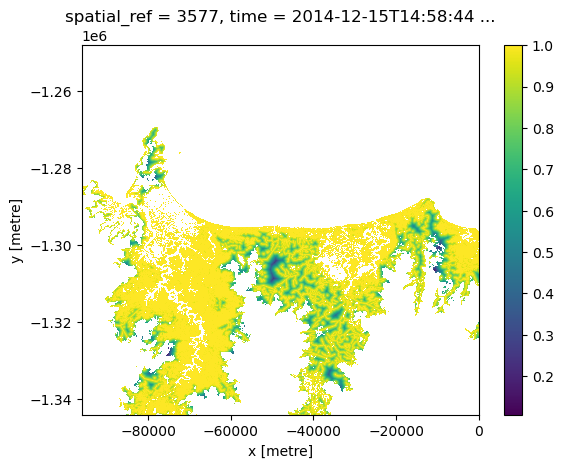

In [26]:
connectivity_tile.plot()

In [27]:
# export
if export == False:
        pass
else:
    write_cog(geo_im=connectivity_mask,
      fname=vector_file.rsplit('/', 1)[-1].split('.')[0] + '_gridID_' + str(row['id']) +'_connectivity_mask_' + time_range[0] + '.tif', # first part gets AOI name
      overwrite=True,
      nodata=0.0)
    write_cog(geo_im=connectivity_tile,
      fname=vector_file.rsplit('/', 1)[-1].split('.')[0] + '_gridID_' + str(row['id']) +'_connectivity_tile_' + time_range[0] + '.tif', # first part gets AOI name
      overwrite=True,
      nodata=0.0)